In [ ]:
#default_exp nlp.word_embedding

In [ ]:
#export
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from  tensorflow.keras.preprocessing import sequence
import tensorflow_datasets as tfds
import numpy as np
import json
import matplotlib.pyplot as plt

In [ ]:
#hide
print(tf.__version__)

2.4.1


In [ ]:
#hide
print("# of GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

# of GPUs: 1


# Tạo dữ liệu

## Download dữ liệu tfds

`load` is a convenience method that fetches the `tfds.core.DatasetBuilder` by
string name, optionally calls `DatasetBuilder.download_and_prepare`
(if `download=True`), and then calls `DatasetBuilder.as_dataset`.
This is roughly equivalent to:

```
builder = tfds.builder(name, data_dir=data_dir, **builder_kwargs)
if download:
  builder.download_and_prepare(**download_and_prepare_kwargs)
ds = builder.as_dataset(
    split=split, as_supervised=as_supervised, **as_dataset_kwargs)
if with_info:
  return ds, builder.info
return ds
```

In [ ]:
#export
## Download dữ liệu:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /home/ddpham/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#hide
# Kiểm tra loại dữ liệu của imdb:
imdb.__class__

dict

In [ ]:
#hide
imdb.keys()

dict_keys([Split('train'), Split('test'), Split('unsupervised')])

In [ ]:
#export
# Tạo tập train, valid:
train_ds, valid_ds = imdb['train'], imdb['test']

In [ ]:
#hide
train_ds.__class__

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
#hide
# Kiểm tra dữ liệu:
for s, l in train_ds.take(1):
    print(s)
    print(l)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
#export
# Chuyển đổi dữ liệu sang dạng string:
train_sentences = []
train_labels = []
for s, l in train_ds:
    train_sentences.append(str(s.numpy())) # bổ sung từng câu dưới dạng string vào list
    train_labels.append(l.numpy()) # bổ sung nhãn dưới dạng số vào list
print(f'#{len(train_sentences)}:')
print(train_sentences[0])
print(train_labels[0])
print(f'Số lượng labels: {set(train_labels)}')

#25000:
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
Số lượng labels: {0, 1}


In [ ]:
#export
# Làm tương tự với dữ liệu valid:
valid_sentences = []
valid_labels = []

for s, l in valid_ds:
    valid_sentences.append(str(s.numpy()))
    valid_labels.append(l.numpy())
print(f'#{len(valid_sentences)}:')
print(valid_sentences[0])
print(valid_labels[0])

#25000:
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
1


__Lưu ý:__
Như vây chúng ta đã có cả dữ liệu về train, valid, với cùng độ dài là 2500 câu. Và nhãn ở dạng binary (0, 1).

## Tokenize

In [ ]:
#export
vocab_size = 10000
embedding_dim = 16
max_len = 120
trunc_type = 'post'
oov_tok = 'UNK'
# Tạo tokenizer và fit dữ liệu train:
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

# Tạo word_index, sequences, pad_sequences từ tập train:
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_sentences)
padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len, padding='post', truncating=trunc_type)

# Tạo sequences, pad_sequences từ tập valid:
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
padded_valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating=trunc_type)

In [ ]:
#export
# Biến đổi dữ liệu:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

# Tạo Wordembedding Model

In [ ]:
#export
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len)
    , keras.layers.Flatten()
    , keras.layers.Dense(6, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
# Đào tạo:
model.fit(padded_sequences, train_labels, batch_size=64, epochs=10, validation_data=(padded_valid_sequences, valid_labels))

Epoch 1/10
391/391 [==============================] - 10s 20ms/step - loss: 0.6915 - accuracy: 0.5246 - val_loss: 0.6548 - val_accuracy: 0.6803
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 0.5679 - accuracy: 0.7709 - val_loss: 0.4229 - val_accuracy: 0.8150
Epoch 3/10
391/391 [==============================] - 8s 22ms/step - loss: 0.3401 - accuracy: 0.8682 - val_loss: 0.3779 - val_accuracy: 0.8318
Epoch 4/10
391/391 [==============================] - 9s 23ms/step - loss: 0.2564 - accuracy: 0.9058 - val_loss: 0.3741 - val_accuracy: 0.8325
Epoch 5/10
391/391 [==============================] - 8s 22ms/step - loss: 0.2094 - accuracy: 0.9289 - val_loss: 0.3814 - val_accuracy: 0.8316
Epoch 6/10
391/391 [==============================] - 8s 19ms/step - loss: 0.1662 - accuracy: 0.9493 - val_loss: 0.4002 - val_accuracy: 0.8260
Epoch 7/10
391/391 [==============================] - 9s 23ms/step - loss: 0.1300 - accuracy: 0.9661 - val_loss: 0.4190 - val_accuracy: 0.822

## Kiểm tra kết quả

In [ ]:
#export
history = model.history

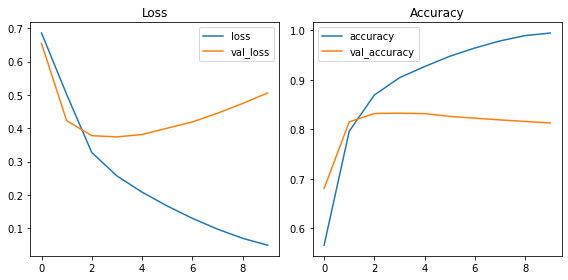

In [ ]:
#export
figure = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.tight_layout()

Chúng ta có thể thấy, chỉ sau khoảng 4 epoch thì cả loss và accuracy của tập valid có dấu hiệu giảm về chất lượng (loss tăng, accuracy giảm).

## Word projector
> Chúng ta có thể lưu lại kết quả và sử dụng [tensorflow projector](https://projector.tensorflow.org/) để tìm các từ đồng nghĩa hoặc trái nghĩa nhau.

In [ ]:
#export
embedding = model.layers[0]
embed_weights = embedding.get_weights()[0]
embed_weights.shape

(10000, 16)

In [ ]:
#hide
embed_weights[:5,:5]

array([[ 0.05762896, -0.04024282, -0.03685305, -0.01116298, -0.08026509],
       [ 0.00254755, -0.01014914,  0.06399544, -0.02689928, -0.08736194],
       [ 0.03840657,  0.00719289,  0.04249526, -0.00602993, -0.07511905],
       [ 0.0813643 , -0.01940138,  0.04226055,  0.02628971, -0.06793556],
       [ 0.08734765, -0.05658243,  0.00181884,  0.03746496, -0.13329737]],
      dtype=float32)

In [ ]:
#export
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# index của từ điển bắt đầu từ 1:
for idx in range(1, vocab_size):
    word = tokenizer.sequences_to_texts([[idx]])[0] # sequences_to_texts có input là list và output là list, 
    #nên chúng ta phải để idx dưới dạng list và lấy idx position =0 cho output
    e_w = embed_weights[idx] ## lấy sequence weights của từng từ
    out_m.write(word + '\n') # ghi lại từ
    out_v.write('\t'.join([str(x) for x in e_w]) + '\n')
out_m.close()
out_v.close()  

Sau khi đã có được dữ liệu về từ và vector weights của các từ vs nhau (embedding_weights), chúng ta có thể load files lên projector để kiểm tra kết quả:
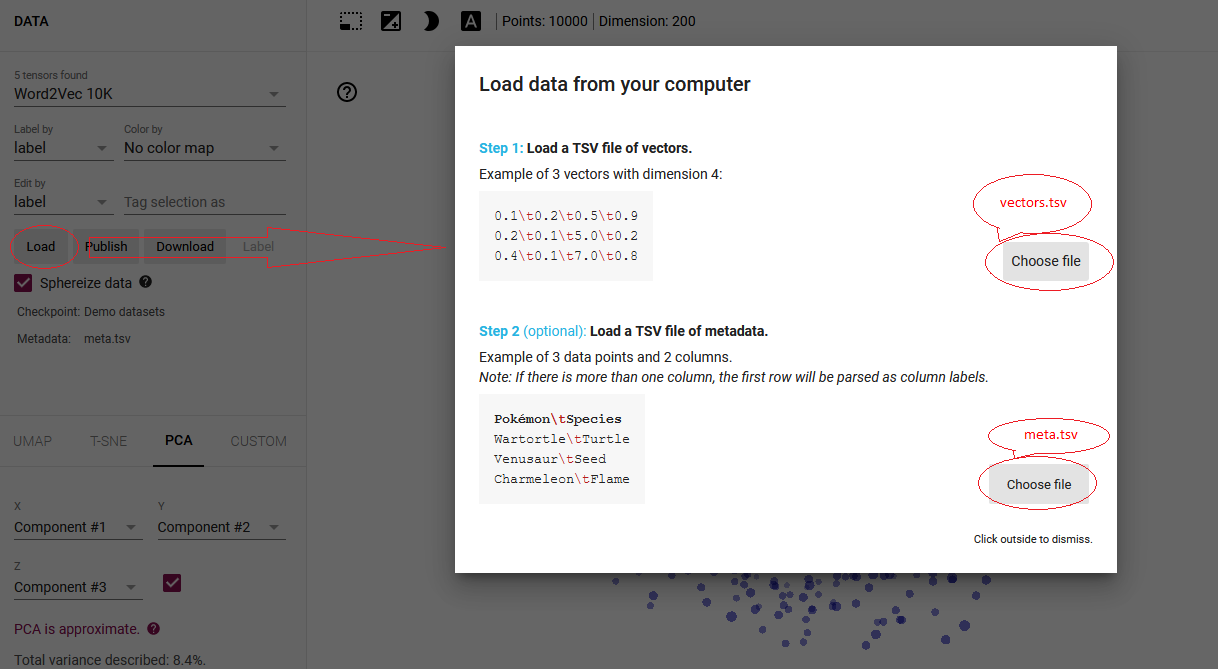

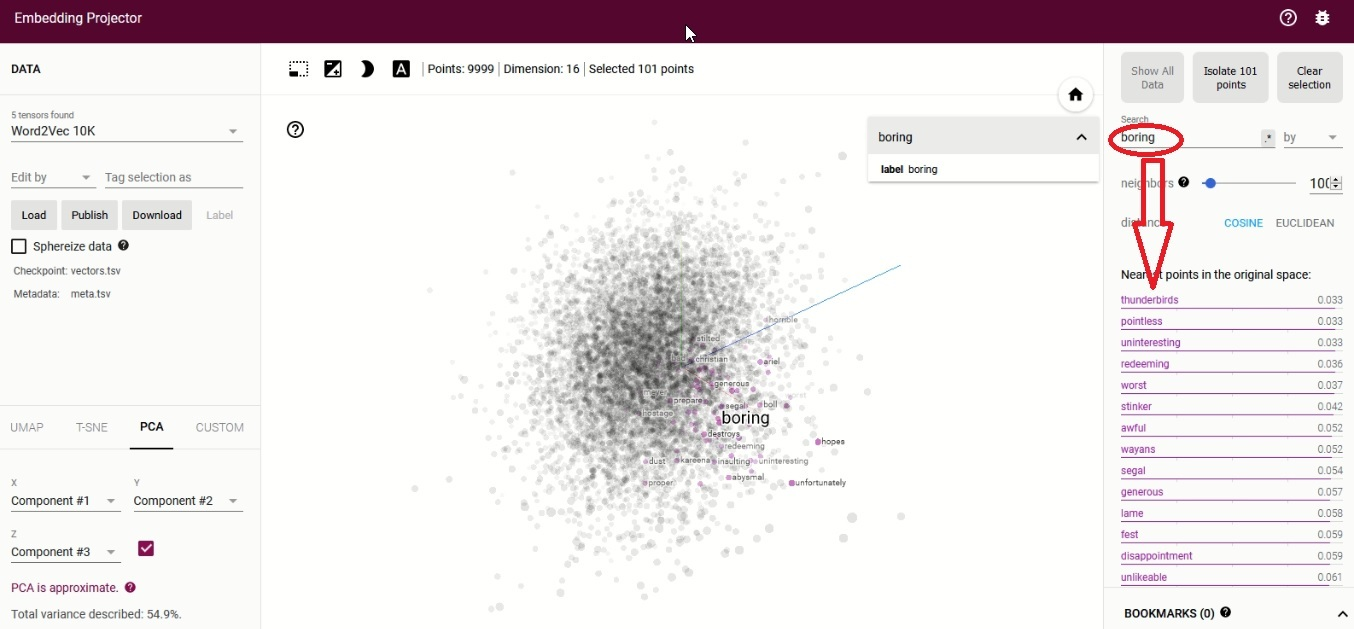

# Sarcasm Dataset

In [ ]:
#export
sentences = []
labels = []
urls = []

file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
file = open(file_name, 'r')
for line in file.readlines():
    line = json.loads(line)
    sentences.append(line['headline'])
    labels.append(line['is_sarcastic'])
    urls.append(line['article_link'])
file.close()

In [ ]:
#hide
print(f'#{len(sentences)}:\n{sentences[0]}, \n{labels[0]}, \n{urls[0]}')

#26709:
former versace store clerk sues over secret 'black code' for minority shoppers, 
0, 
https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5


## Tokenization

In [ ]:
#export
num_words = 10000
embed_dim = 16
# max_len=20
trunc_type='post'
padding_type='post'
oov_token = 'UNK'
training_size = 20000

In [ ]:
#export
train_sentences = sentences[:training_size]
valid_sentences = sentences[training_size:]
train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

In [ ]:
#export
tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sentences = tokenizer.texts_to_sequences(train_sentences)
valid_sentences = tokenizer.texts_to_sequences(valid_sentences)

In [ ]:
#export
# Chúng ta hay kiểm tra một chút về độ dài của tất cả các câu:
len_sentences = []
for i in train_sentences:
    len_sentences.append(len(i))
len_dict = dict.fromkeys(set(len_sentences), 0)
for length in len_sentences:
    len_dict[length] += 1
len_dict

{2: 85,
 3: 228,
 4: 380,
 5: 777,
 6: 1218,
 7: 1640,
 8: 2048,
 9: 2406,
 10: 2569,
 11: 2470,
 12: 2082,
 13: 1457,
 14: 1027,
 15: 638,
 16: 397,
 17: 267,
 18: 142,
 19: 63,
 20: 43,
 21: 24,
 22: 18,
 23: 8,
 24: 3,
 26: 2,
 27: 1,
 28: 1,
 29: 1,
 30: 2,
 31: 1,
 39: 1,
 40: 1}

<AxesSubplot:xlabel='len'>

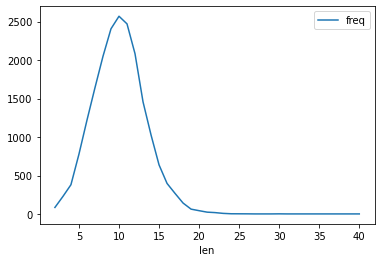

In [ ]:
# Vẽ đồ thị histogram về tần suất độ dài:
import pandas as pd
pd.DataFrame(list(len_dict.items()), columns=['len', 'freq']).plot('len', 'freq')

In [ ]:
#export
# Padding:
train_sentences = sequence.pad_sequences(train_sentences, padding=padding_type, truncating=trunc_type)
valid_sentences = sequence.pad_sequences(valid_sentences, padding=padding_type, truncating=trunc_type)

In [ ]:
#hide
train_sentences.shape, valid_sentences.shape

((20000, 40), (6709, 38))

In [ ]:
#hide
train_sentences[5:10, 10:15]

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [150,   6,  33, 343,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=int32)

## Tạo model

In [ ]:
#export
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.GlobalAveragePooling1D()
    , keras.layers.Dense(24, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
n = 30
model.fit(train_sentences, train_labels, epochs=n, validation_data=(valid_sentences, valid_labels), verbose=2)

Epoch 1/30


625/625 - 10s - loss: 0.6280 - accuracy: 0.6443 - val_loss: 0.5071 - val_accuracy: 0.7846
Epoch 2/30
625/625 - 8s - loss: 0.4170 - accuracy: 0.8254 - val_loss: 0.4005 - val_accuracy: 0.8189
Epoch 3/30
625/625 - 8s - loss: 0.3384 - accuracy: 0.8554 - val_loss: 0.3658 - val_accuracy: 0.8422
Epoch 4/30
625/625 - 8s - loss: 0.3021 - accuracy: 0.8739 - val_loss: 0.3603 - val_accuracy: 0.8422
Epoch 5/30
625/625 - 9s - loss: 0.2796 - accuracy: 0.8834 - val_loss: 0.3537 - val_accuracy: 0.8526
Epoch 6/30
625/625 - 9s - loss: 0.2649 - accuracy: 0.8909 - val_loss: 0.3535 - val_accuracy: 0.8512
Epoch 7/30
625/625 - 9s - loss: 0.2540 - accuracy: 0.8966 - val_loss: 0.3584 - val_accuracy: 0.8498
Epoch 8/30
625/625 - 9s - loss: 0.2464 - accuracy: 0.8996 - val_loss: 0.3591 - val_accuracy: 0.8524
Epoch 9/30
625/625 - 9s - loss: 0.2399 - accuracy: 0.9041 - val_loss: 0.3627 - val_accuracy: 0.8526
Epoch 10/30
625/625 - 9s - loss: 0.2353 - accuracy: 0.9068 - val_loss: 0.3628 - val_accuracy: 0.8523
Epoch 11/

In [ ]:
#export
history = model.history

In [ ]:
#hide
# Chúng ta muốn vẽ kết quả của lần train vừa rồi 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

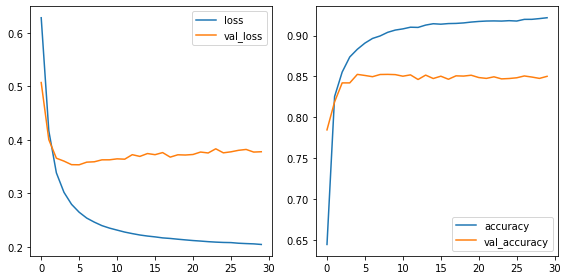

In [ ]:
#export
# Sử dụng loop:
item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
plot_list = ['Loss', 'Accuracy']
plt.figure(figsize=(8, 4))
for i in range(len(plot_list)):
    plt.subplot(1, 2, i+1)
    item = plot_list[i]
    for items in item_dict[item]:
        plt.plot(history.history[items])
    plt.legend(item_dict[item])
plt.tight_layout()

In [ ]:
#export
# Tạo hàm plot:
def plot_history(history):
    item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
    plot_list = ['Loss', 'Accuracy']
    plt.figure(figsize=(8, 4))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

__Lưu ý:__ 
Chúng ta có thể thấy được kết quả của việc train dữ liệu thông qua việc visualize loss và metric.

Nhìn vào đồ thị, chúng ta có thể thấy, chỉ với dưới 3 epochs, dữ liệu của tập validate đã có dấu hiện bị overfit khi cả giá trị loss và giá trị accuracy đều không có tiến triển.

## Tunning model
> Chúng ta thử thay đổi một vài hyper-parameters để xem kết quả của model có được cải thiện không.

In [ ]:
#export
num_words = 1000 # giảm từ 10K
max_len = 20 # giảm từ 40
embed_dim = 15 # giảm từ 16
trunc_type = 'post'
pad_type = 'post'
oov_token = 'UNK'
training_size = 18000 # tăng size cho tập valid

In [ ]:
#export
# Parse dữ liệu
sentences = []
labels = []
urls = []

file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
file = open(file_name, 'r')
for line in file.readlines():
    line = json.loads(line)
    sentences.append(line['headline'])
    labels.append(line['is_sarcastic'])
    urls.append(line['article_link'])
file.close()

train_sentences = sentences[:training_size]
valid_sentences = sentences[training_size:]
train_labels = labels[:training_size]
valid_labels = labels[training_size:]

In [ ]:
#export
# Tokenize & padding:
tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_token)
# dir(tokenizer)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
# Kiểm tra shape:
train_sequences.shape, valid_sequences.shape

((18000, 20), (8709, 20))

### Tạo neural net mới

In [ ]:
#export
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.GlobalAveragePooling1D()
    , keras.layers.Dense(24, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 15)            15000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                384       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 15,409
Trainable params: 15,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(train_sequences, train_labels, epochs=10, batch_size=32, validation_data=(valid_sequences, valid_labels))

Epoch 1/10
563/563 [==============================] - 11s 18ms/step - loss: 0.6387 - accuracy: 0.6267 - val_loss: 0.4381 - val_accuracy: 0.7876
Epoch 2/10
563/563 [==============================] - 9s 17ms/step - loss: 0.3948 - accuracy: 0.8205 - val_loss: 0.3969 - val_accuracy: 0.8185
Epoch 3/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3591 - accuracy: 0.8360 - val_loss: 0.3943 - val_accuracy: 0.8159
Epoch 4/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3620 - accuracy: 0.8369 - val_loss: 0.3974 - val_accuracy: 0.8183
Epoch 5/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3544 - accuracy: 0.8397 - val_loss: 0.3983 - val_accuracy: 0.8135
Epoch 6/10
563/563 [==============================] - 8s 15ms/step - loss: 0.3407 - accuracy: 0.8488 - val_loss: 0.4014 - val_accuracy: 0.8169
Epoch 7/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3416 - accuracy: 0.8462 - val_loss: 0.4008 - val_accuracy: 0.811

In [ ]:
#export
history = model.history

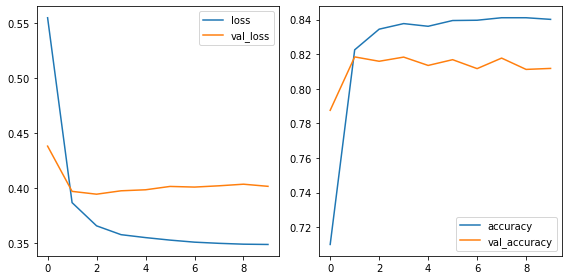

In [ ]:
#export
# Visualize:
plot_history(history)

__NOTE:__
Chúng ta có thể thấy, mặc dù accuracy của valid giảm xuống tương đối (3%), nhưng mức độ overfit của model rõ ràng đã cải thiện đáng kể. Khoảng cách giữa train và valid đã thu hẹp tương đối nhiều (giảm > 2 lần) cho cả loss và accuracy.

Chúng ta có thể thử tiếp vs max_len=15, embed_dim=10 để kiểm tra model có cải thiện về mức độ overfit hay ko. Tất nhiên, khi chúng ta giảm chiều xuống thì sẽ ít hơn số lượng từ tương đồng hoặc đối lập nhau để có thể view được những từ có ý nghĩa hơn và những từ tương đồng hay đối lập thường sẽ rất hiển nhiên.

### Word projector
Tương tự như cách thức ở trên, hãy tạo ra vectors và weights để projects tương quan giữa các từ vs nhau:

In [ ]:
#export
sarcasm_emb = model.layers[0]
sarcasm_weights = sarcasm_emb.get_weights()[0]
sarcasm_weights.shape

(1000, 15)

In [ ]:
#export
sarc_meta = io.open('sarcasm_meta.tsv', 'w', encoding='utf-8')
sarc_vect = io.open('sarcasm_vectors.tsv', 'w', encoding='utf-8')

for idx in range(1, num_words):
    word = tokenizer.sequences_to_texts([[idx]])[0]
    weights = sarcasm_weights[idx]
    sarc_meta.write(word + '\n')
    sarc_vect.write('\t'.join([str(x) for x in weights]) + '\n')
sarc_meta.close()
sarc_vect.close()

# Giới thiệu về subword tokenizer
> Khác với tokenizer chúng ta biết ở trên, các từ được gán với id (dạng số nguyên dương) và được hợp thành sequences để đào tạo model. Tuy nhiên, với subword tokenizer, một từ có thể được tách ra nhỏ hơn.
> Phần này tạm thời dừng lại ở đây!